# ANNDL: 1st challenge


## ⚙️ Import Libraries
Import the libraries needed for the project and fix the seed for repeatability.

In [1]:
import numpy as np



from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow import random as tfr

import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

seed = 42
input_img_size = 96

np.random.seed(seed)
tfr.set_seed(seed)

## ⏳ Load the Data

The data are loaded from the filtered, pre-processed data. For more details, see '''Preprocessing.ipynb''' notebook.

In [2]:
filtered_dataset_path = '../Preprocessing/augmented_dataset.npz'
data = np.load(filtered_dataset_path)
X_train = data['images_t']
y_train = data['labels_t']
X_val = data['images_v']
y_val = data['labels_v']

# Define a mapping of labels to their corresponding digit names
labels = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}

# Save unique labels
unique_labels = list(labels.values())

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,         # Equivalent to RandomRotation
    width_shift_range=0.2,     # Equivalent to RandomTranslation on x-axis
    height_shift_range=0.2,    # Equivalent to RandomTranslation on y-axis
    zoom_range=0.2,            # Equivalent to RandomZoom
    horizontal_flip=True,      # Equivalent to RandomFlip (horizontal)
    vertical_flip=True         # Equivalent to RandomFlip (vertical)
)

train_generator = datagen.flow(X_train, y_train)

## Transfer Learning

In [4]:
# Initialise densenet model with pretrained weights, for transfer learning

dense = tfk.applications.densenet.DenseNet121(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet',
    pooling=None,
    classifier_activation='softmax'
)

# Display a summary of the model architecture
# dense.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(dense, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [5]:
print(len(dense.layers))
#dense.summary(expand_nested=True, show_trainable=True)
#Tipi di layer nella rete, fine tuning potrebbe fare tanto
#Sequential Conv2d LayerNormalization Dense LayerScale 

427


In [ ]:
# Freeze all layers in DenseNet to use it solely as a feature extractor
dense.trainable = False

l2_lambda = 0.0001
# Define input layer with shape matching the input images
inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')

# Pass inputs through the feature extractor
x = dense(inputs)

# Add a Global Average Pooling layer to flatten the spatial dimensions
x = tfkl.GlobalAveragePooling2D(name='global_avg_pool')(x)

# Add a dropout layer for regularisation
x = tfkl.Dropout(0.5, name='dropout')(x)

x = tfkl.Dense(units = 64,
               kernel_regularizer = tfk.regularizers.L2(l2_lambda),
            #   bias_regularizer = tfk.regularizers.L2(l2_lambda),
            #   activity_regularizer = tfk.regularizers.L2(l2_lambda),
              name = "DenseRegularizer")(x)

x = tfkl.Dropout(0.3, name='dropoutAfterReg')(x)

# Add final Dense layer for classification with softmax activation
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)

# Define the complete model linking input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with categorical cross-entropy loss and Adam optimiser
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display a summary of the model architecture
# tl_model.summary(expand_nested=True)

In [7]:
# Train the model
tl_history = tl_model.fit(
    train_generator,
    batch_size=16,
    epochs=12,
    validation_data=(X_val, y_val),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=2, restore_best_weights=True)]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = 'TL_dense_' + str(final_val_accuracy) + '.keras'
tl_model.save(model_filename)

# Free memory by deleting the model instance
del tl_model

Epoch 1/12


d:\ANN\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1224/1224 ━━━━━━━━━━━━━━━━━━━━ 305s 240ms/step - accuracy: 0.4708 - loss: 3.0132 - val_accuracy: 0.5347 - val_loss: 1.4599
Epoch 2/12
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 295s 241ms/step - accuracy: 0.6173 - loss: 1.3645 - val_accuracy: 0.5680 - val_loss: 1.3089
Epoch 3/12
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 297s 243ms/step - accuracy: 0.6177 - loss: 1.3041 - val_accuracy: 0.5567 - val_loss: 1.4410
Epoch 4/12
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 295s 241ms/step - accuracy: 0.6180 - loss: 1.2986 - val_accuracy: 0.5604 - val_loss: 1.4860
Final validation accuracy: 56.8%


## 🛠️ Train and Save the Model

175/175 ━━━━━━━━━━━━━━━━━━━━ 41s 216ms/step


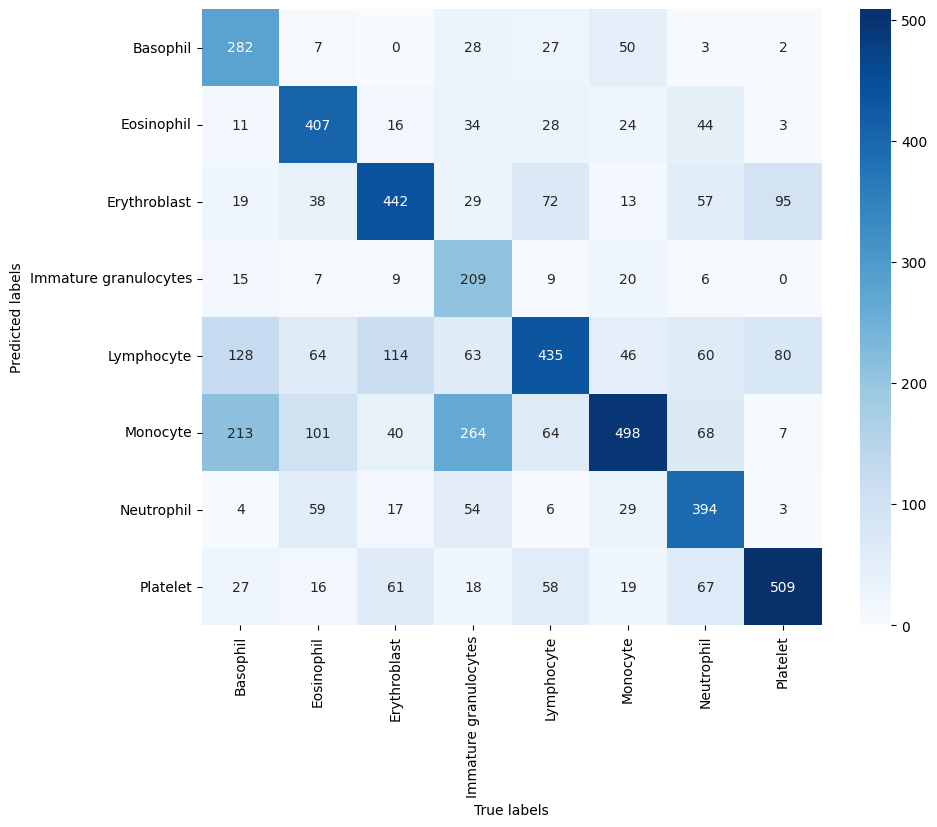

In [8]:
# Load the saved model
model = tfk.models.load_model(model_filename)

# Compute the confusion matrix
predictions = model.predict(X_val)
pred_classes = np.argmax(predictions, axis=-1)
true_classes = np.argmax(y_val, axis=-1)
cm = confusion_matrix(true_classes, pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, annot=True, fmt='', xticklabels=unique_labels, yticklabels=unique_labels, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

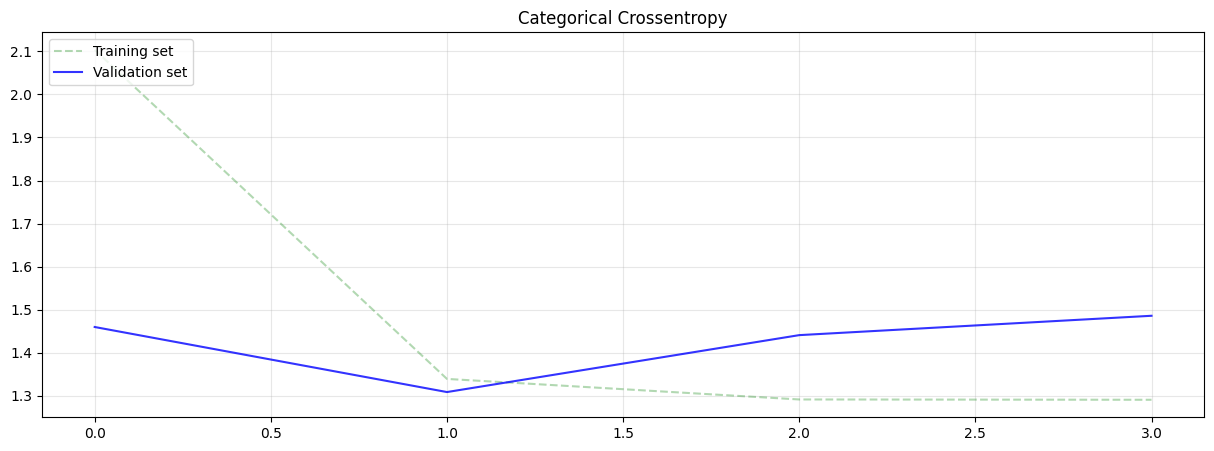

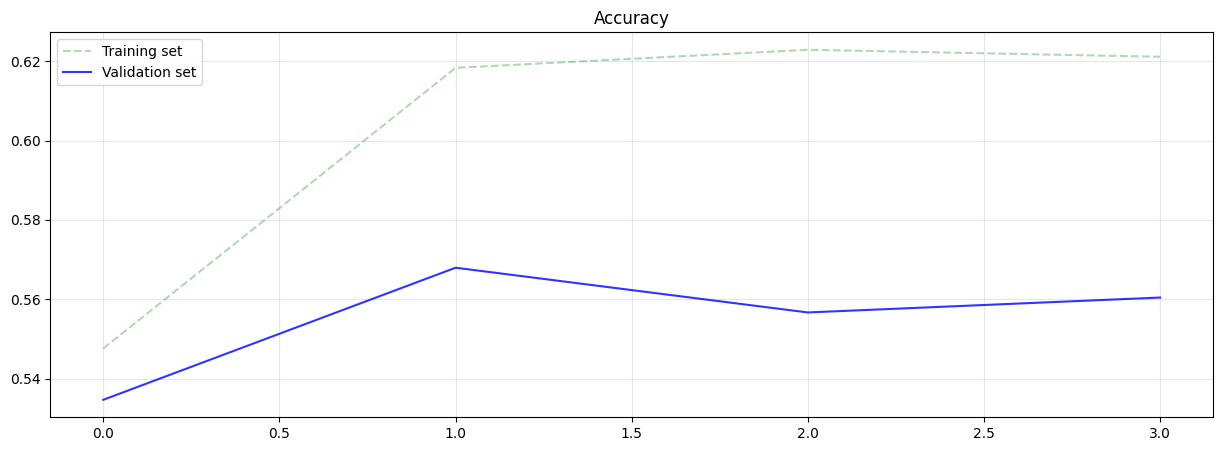

In [9]:
# Plot the loss and accuracy metrics
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], label='Training set', alpha=.3, color='green', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation set', alpha=.8, color='blue')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], label='Training set', alpha=.3, color='green', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation set', alpha=.8, color='blue')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```


In [10]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        X = X / 255.0
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [11]:
# Create the .zip file to be submitted
import os
import zipfile

# Check if model.py and weights.keras exist
if os.path.exists("model.py") and os.path.exists("weights.keras"):
    # Create a ZIP file containing model.py and weights.keras
    with zipfile.ZipFile("sub.zip", "w") as model_zip:
        model_zip.write("model.py")
        model_zip.write("weights.keras")
    print("model.zip has been created successfully.")
else:
    print("model.py or weights.keras not found. Please ensure both files are in the current directory.")

model.py or weights.keras not found. Please ensure both files are in the current directory.
